In [1]:
#|default_exp app

In [18]:
from fastcore.all import *
import time
import timm

def search_images(term, max_images = 250):
    url = "https://duckduckgo.com/"
    res = urlread(url, data = {"q":term})

ModuleNotFoundError: No module named 'ndev'

In [2]:
from fastbook import *
from fastai.vision.widgets import *

def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images=max_images))

In [3]:
urls = search_images('building broken window', max_images=1)
urls[0]

Searching for 'building broken window'


'https://i0.wp.com/nearlylegal.co.uk/wp-content/uploads/2019/01/Broken-Window.jpg?resize=1024%2C697&ssl=1'

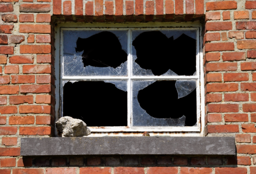

In [4]:
from fastdownload import download_url
dest = 'broken_window.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'building window'


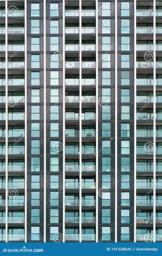

In [5]:
download_url(search_images('building window', max_images=1)[0], 'window.jpg', show_progress=True)
Image.open('window.jpg').to_thumb(256,256)

In [8]:
from pathlib import Path
from fastai.vision.all import *

searches = "broken window", "window"
path = Path("broken_or_not_broken")

In [ ]:
for o in searches:
    dest = (path/o)
    if os.path.isdir(dest) == False:
        dest.mkdir(exist_ok=False, parents=True)
    try:
        download_images(dest, urls=search_images(f"building {o} photo"), preserve_filename=True)
        resize_images(path/o, max_size=400, dest=path/o)
    except:
        continue

In [6]:
?? download_images

Signature:
 download_images(
    dest,
    url_file=None,
    urls=None,
    max_pics=1000,
    n_workers=8,
    timeout=4,
    preserve_filename=False,
)
Source:   
def download_images(dest, url_file=None, urls=None, max_pics=1000, n_workers=8, timeout=4, preserve_filename=False):
    "Download images listed in text file `url_file` to path `dest`, at most `max_pics`"
    if urls is None: urls = url_file.read_text().strip().split("\n")[:max_pics]
    dest = Path(dest)
    dest.mkdir(exist_ok=True)
    parallel(partial(_download_image_inner, dest, timeout=timeout, preserve_filename=preserve_filename),
             list(enumerate(urls)), n_workers=n_workers, threadpool=True)
File:      c:\users\bimicon\appdata\local\programs\python\python312\lib\site-packages\fastai\vision\utils.py
Type:      function

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

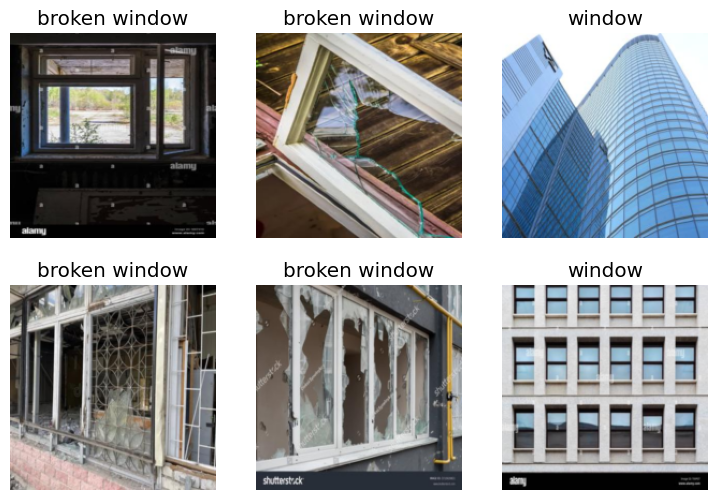

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
).dataloaders(path,bs=64)
dls.show_batch(max_n=6)

In [11]:
import timm
learn = vision_learner(dls, 'convnext_tiny.fb_in22k', metrics=error_rate)
learn.fine_tune(3)

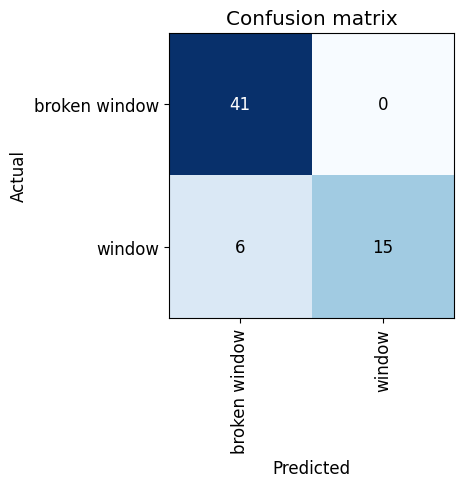

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

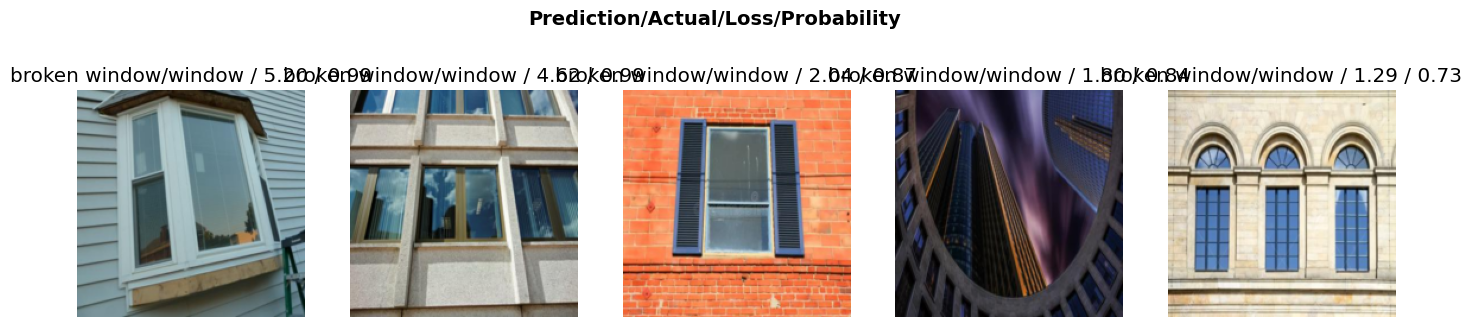

In [13]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

In [14]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [15]:
is_window_broken,_,probs = learn.predict(PILImage.create("window.jpg"))
print(f"This is a: {is_window_broken}.")
print(f"Probability it is broken: {probs[0]:.4f}")

This is a: window.
Probability it is broken: 0.0195


In [42]:
learn.export("model.pkl")

In [68]:
#|export
from fastai.vision.all import *
import gradio as gr
import pathlib

def is_broken(x): return x[0].isupper()

In [69]:
#|export
def load_posix_learner(path):
    save = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    learn = load_learner(path)
    
    pathlib.PosixPath = save
    return learn

In [70]:
#|export
learn = load_posix_learner('model.pkl')

In [71]:
#|export
categories = ('Broken window', 'Not broken window')

def classify_image(img):
    pred, idx, probs = learn.predict(img)
    return dict(zip(categories, map(float, probs)))

In [72]:
#|export
image = gr.Image()
label = gr.Label()
examples = ['odd_broken_window.jpg', 'broken_window.jpg', "window_error.jpg"]

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.


In [73]:
import nbdev

In [74]:
nbdev.export.nb_export('broken_windows.ipynb', 'app')

In [75]:
?? nbdev.export.nb_export


Signature:
 nbdev.export.nb_export(
    nbname,
    lib_path=None,
    procs=None,
    debug=False,
    mod_maker=<class 'nbdev.maker.ModuleMaker'>,
    name=None,
)
Source:   
def nb_export(nbname, lib_path=None, procs=None, debug=False, mod_maker=ModuleMaker, name=None):
    "Create module(s) from notebook"
    if lib_path is None: lib_path = get_config().lib_path
    exp = ExportModuleProc()
    nb = NBProcessor(nbname, [exp]+L(procs), debug=debug)
    nb.process()
    for mod,cells in exp.modules.items():
        all_cells = exp.in_all[mod]
        nm = ifnone(name, getattr(exp, 'default_exp', None) if mod=='#' else mod)
        if not nm:
            warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
                 "Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.\n"
                 "See https://nbdev.fast.ai/getting_started.html for more information.")
            return
        mm = mod_maker(dest=lib_path, name=nm, nb_pat